## Health Data Reusability Project

This notebook is an informal investigation into the technologies needed to take the data contained in "open data" publications from the UK Department of Health. This will allow researchers to automate computations and respond more speedily to changes.

Some of this is ugly, some of it will doubtless be unnecessary, but it shows at least some of the preliminary work that goes into getting one's thinking straightened out about a particular program or set of programs.

In [168]:
import openpyxl as xl

Note that this softare cannot read ".xls" files. `wb = xl.load_workbook("data/gpearnextime.xls")` raises an exception, so I toook the quick route and converted it to a ".xlsx" file with Word before further processing.

It might be worth investigating the older `xlrd` module, which can reals ".xls" files (though sadly there appears
to be no easy way to write them out as ".xslx" files which I had hopes `xlwt` might have provided. I suspect that there will be an easy fix for this, but I'll need to speak to Chris Withers.

In [169]:
wb = xl.load_workbook("data/gpearnextime.xlsx")

/Users/sholden/Projects/HealthData/hd.env/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:122: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")
/Users/sholden/Projects/HealthData/hd.env/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:150: UserWarning: Invalid range_names: _A1, _Cal05, _Cc1, _Dd1, _Ee1, _Ff1, newname1, _xlnm.Print_Area, _xlnm.Print_Titles
  warnings.warn("Invalid range_names: "+", ".join(invalid_range_names))


In [170]:
wb.sheetnames

['Contents',
 'Definitions and Changes',
 '1a. GPMS Cash Terms ',
 '1b. GPMS Real Terms',
 'Real terms working - HIDE',
 '1c. GMS',
 '1d. PMS',
 '2a. GPMS Expenses',
 '2b. GMS Expenses',
 '2c. PMS Expenses',
 '3a. GPMS by Age ',
 '3b. GPMS by Age ',
 '4a. GPMS by Rurality ',
 '4b. GPMS by Rurality ',
 '5a. GPMS by Practice Size',
 '5b. GPMS by Practice Size',
 '6a. GPMS by SHA_GOR',
 '6b. GPMS by SHA_GOR ',
 '7a. GPMS by NHS ER',
 '7b. GPMS by NHS ER',
 '8. GPMS Distribution',
 '9a. All Salaried',
 '9b. Salaried by Country ',
 '9c. Salaried by Age',
 '9d. Salaried by Rurality',
 '9e. Salaried by SHA_GOR',
 '9f. Salaried by NHS ER',
 '10. Salaried Distribution ',
 '11. Combined GPs']

In [171]:
ws = wb.get_sheet_by_name('1a. GPMS Cash Terms ')

In [172]:
ws["B7"].value

'All Practice Types'

In [173]:
for i in range(1, 200):
    print(ws["B{}".format(i)].value, ws["C{}".format(i)].value)

Return to contents None
None None
GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS 
UK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND None
None None
GPMS UK None
Practice Type Year
All Practice Types 2002/031
None 2003/041
None 2004/05
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/11
None 2011/12
None 2012/13
All Dispensing 2002/031
None 2003/041
None 2004/05
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/11
None 2011/12
None 2012/13
All Non-Dispensing 2002/031,2
None 2003/041,2
None 2004/05
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/11
None 2011/12
None 2012/13
None None
None None
GPMS ENGLAND None
Practice Type Year
All Practice Types 2002/03
None 2003/04
None 2004/05
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/11
None 2011/12
None 2012/13
All Dispensing 2002/03
None 2003/04
None 2004/053
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/

Note that the date values and the footnote numbers run together to give a single string value.
That means some parsing has to be applied to separate it into a `(date, footnote)` pair, whose
second member will be `None` if no notes apply.
From an openness point of view it would be much better to have a separate column for the footnotes that should be applied to the row.
Then again, from an openness point of view it would be better not to use Excel spreadsheets 

Turns out that may not be as useful as I thought. It would probably be eaiser to maintain the column values as part ofthe processing logic.

(This was borne out when I wrote a non-terminting loop when experimenting with the code below)

In [174]:
ws["B3"].value

'GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS \nUK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND'

In [175]:
def year_refs(s):
    """Separate the year string into the year plus the list of references"""
    return s[:7], s[7:].split(",")

In [176]:
ws["d81"].value

'-'

In [177]:
def num_val(val):
    return 0 if val == "-" else val

In [178]:
num_val(32.456)

32.456

In [179]:
num_val("-")

0

In [180]:
3 == "banana"

False

In [181]:
cell = ws["B3"]

Probably a good idea to look at how we can find the relevant areas in a worksheet, then analyze the content of those areas (which will vary in size, increasing as the years go by.

In [182]:
ws["B3"].value # Sheet heading

'GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS \nUK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND'

In [183]:
ws["B5"].value # Table heading

'GPMS UK'

In [184]:
cells = ws.get_cell_collection()

In [185]:
from collections import defaultdict

cols_in_row = defaultdict(list)

for cell in cells:
    if cell.value is not None:
        cols_in_row[cell.row].append(cell.column)

In [186]:
max_row = max(c for c in sorted(cols_in_row.keys()))
max_row

198

Note that cell J43 has a spurious value that should really be ignored. Wonder how long that's been there and who knows it is ...

In [187]:
cols_in_row[43].remove('J')
cols_in_row[43]

['C', 'G', 'F', 'D', 'E', 'B']

In [188]:
pixels = [] # straight list of pixel values for graphic
matrix = []
#print("  ".join(list("ABCDEFG"))) # Column headings
for row_num in range(max_row):
    cols = cols_in_row[row_num]
    row_string = []
    row_matrix = []
    for col_name in "ABCDEFG":
        row_string.append("*" if col_name in cols else " ")
        row_matrix.append(col_name in cols)
    #print("  ".join(row_string))
    matrix.append(row_matrix)
    pixels += [1-p for p in row_matrix] + [1]*7 # add pixel row plus blank row

In [189]:
from PIL import Image
im = Image.new("1", (7, 198*2))

In [190]:
im.putdata(pixels)

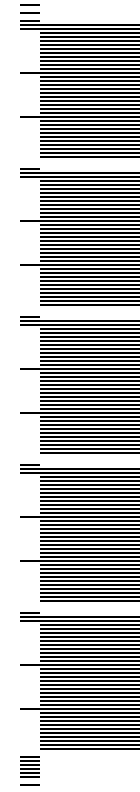

In [191]:
im.resize((7*20, 198*4))

This visualization makes the pattern of the tables more obvious.
Each table begubs with a row with a single cell, followed by two cells with six rows and a number of rows with five cells.
Now, it would be possible to construct a vector with the number of cells in each row, and then search
that for patterns characteristic of the start of a table.
Whenever you find yourself thinking "pattern," though, it's worth considering using Python's `re`
regular expression-based pattern-matching algorithm.
Since no row has more than seven cells we can construct a ___string of row lengths___ and then
use pattern matching to find the starting positions of the tables.
The task then simplifies to finding the string `"1665"`.

In [192]:
str_sizes = "".join(str(sum(x for x in row)) for row in matrix)

In [193]:
import re
for m in re.finditer("(?P<m>1665)", str_sizes):
    print(m.span()[0])

5
42
79
116
153


Maybe there's some easier way to determing the shape without all these complex manipulations.
I don't know about you, but I often find my second approach to a problem is more intelligent
than the first (that's why we are often recommended to write a prototype _and then throw it away_).
So consider everything above as prototypical, offering insight into the necessary analysis but using a horribly inefficient algorithm.

In [194]:
len(ws.columns)

16

In [195]:
col_counts =[sum(cell.value is not None for cell in column) for column in ws.columns]

In [196]:
valid_cols = [i for (i, ct) in  enumerate(col_counts) if ct > 1]
valid_cols

[1, 2, 3, 4, 5, 6]

In [197]:
row_counts =[sum(cell.value is not None for cell in row) for row in ws.rows]
valid_rows = [i for (i, ct) in  enumerate(row_counts) if ct > 0]
len(valid_rows)

185

In [198]:
ncols = len(valid_cols)
max_row_num = max(valid_rows)
pixels = []
row_counts = []
for row in range(max_row_num):
    cell_strings = []
    row_pixels = []
    for col in valid_cols:
        value = ws.rows[row][col].value
        row_pixels.append(value is None)
    pixels += row_pixels*3 + [1]*ncols # blank line
    row_counts.append(sum(1-pixel for pixel in row_pixels))

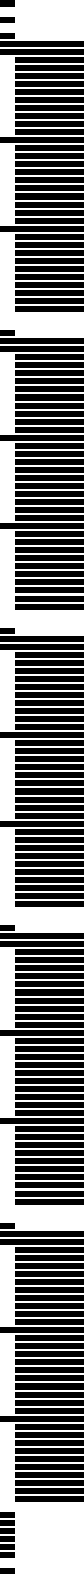

In [199]:
im = Image.new("1", (ncols, 4*(max_row_num)))
im.putdata(pixels)
im.resize((14*ncols, 8*(max_row_num+1)))

It appears that this techmique can be fairly effectively used to get an idea of the shape of a worksheet.
The next step will be to turn that into a function with the worksheet as a parameter, and apply it to all the sheets on a workbook.

In [200]:
%matplotlib inline

In [201]:
def visualize(ws):
    col_counts =[sum(cell.value is not None for cell in column) for column in ws.columns]
    valid_cols = [i for (i, ct) in  enumerate(col_counts) if ct > 1]
    row_counts =[sum(cell.value is not None for cell in row) for row in ws.rows]
    valid_rows = [i for (i, ct) in  enumerate(row_counts) if ct > 0]
    ncols = len(valid_cols)
    max_row_num = max(valid_rows)
    pixels = []
    row_counts = []
    for row in range(max_row_num):
        cell_strings = []
        row_pixels = []
        for col in valid_cols:
            value = ws.rows[row][col].value
            row_pixels.append(value is None)
        pixels += row_pixels*3 + [1]*ncols # blank line
        row_counts.append(sum(1-pixel for pixel in row_pixels))
    im = Image.new("1", (ncols, 4*(max_row_num)))
    im.putdata(pixels)
    return im.resize((14*ncols, 8*(max_row_num+1))), row_counts

In [202]:
images = []; row_counts = []
for ws in wb.worksheets:
    if ws.sheet_state != "hidden": # exclude hidden sheets
        image, counts = visualize(ws)
        images.append(image)
        row_counts.append(counts)

In [203]:
LEFT_MARGIN = 4
im_width = sum(i.size[0] for i in images)+(len(images)-1)*LEFT_MARGIN
im_height = max(i.size[1] for i in images)
im_width, im_height

(3370, 2680)

In [204]:
len(row_counts)

28

In [205]:
x_offset = 0
big_image = Image.new("1", (im_width, im_height), 1)
for i, im in enumerate(images):
    big_image.paste(im, (x_offset, 0))
    x_offset += im.size[0]+LEFT_MARGIN

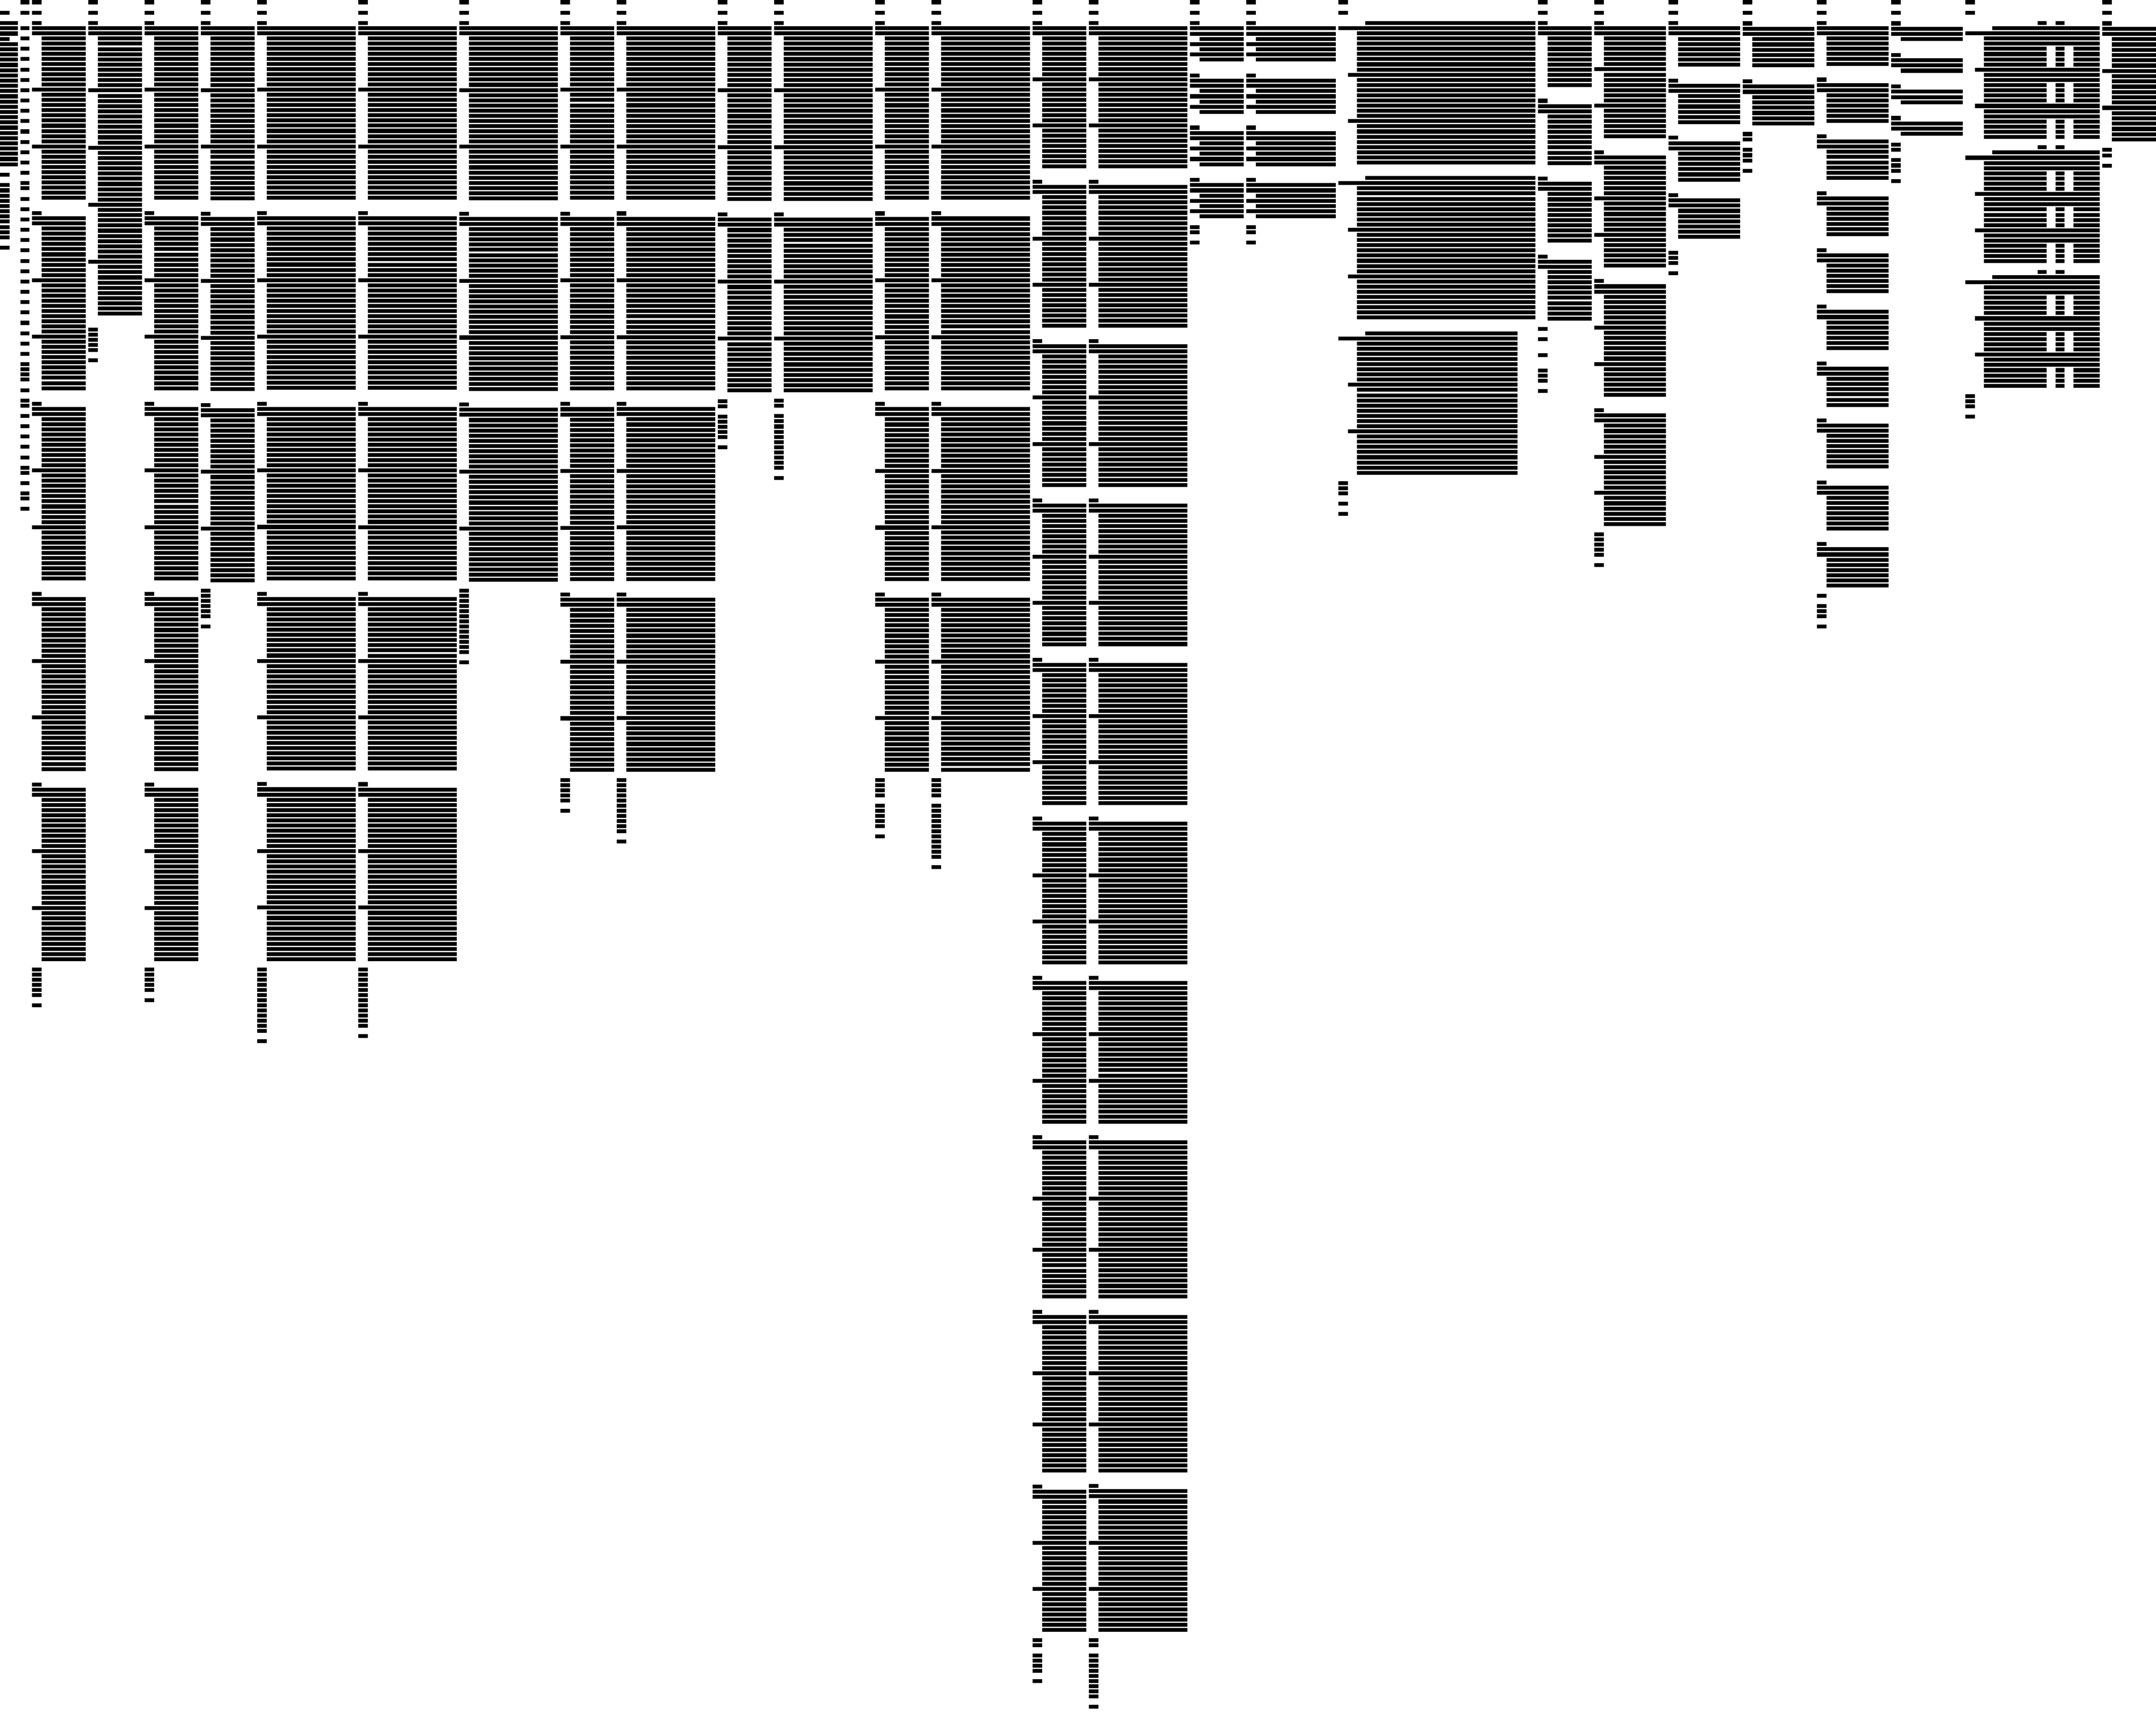

In [206]:
big_imageaccep

In [207]:
ws = wb.worksheets[2]
ws

<Worksheet "1a. GPMS Cash Terms ">

In [208]:
# Page header is in B3 always?
page_header = ws["B3"].value
print(page_header)

GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS 
UK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND


In [209]:
counts_string = "".join(str(n) for n in row_counts[2])
counts_string

'10101665555555555655555555556555555555500166555555555565555555555655555555550016655555555556555555555565555555555001665555555555655555555556555555555500166555555555565555555555655555555550111111010'

Looking for the pattern `"1665"`\* in `counts_string` finds a six-column table.
The first line is the name of the table.
The second line is the column headings.
The remainder of the table is a number of repeating groups.
The first column is special because unchanged values aren't repeated (which is why subsequent lines only have five elements).
While this is helpful for the human reader's comprehension it has to be corrected for the computer.

\* Yes, this is a fix - that string was chosen because I knew there were six columns in the tables.
We may or may not get to the computation of the number of columns later.

In [210]:
    table_starts = [x.start("X") for x in re.finditer("(?P<X>1665)", counts_string)]
table_starts

[4, 41, 78, 115, 152]

In [211]:
table_lens = [x.end("X")-x.start("X")-1 for x in re.finditer("(1(?P<X>665([56]+)))", counts_string)]
table_lens

[33, 33, 33, 33, 33]

In [212]:
number_of_tables = len(table_starts)
number_of_tables

5

Let's do a little work on the first table.
Also, let's learn how to access the elements we need in order to construct a usable data source.
The crucial facts for each table are the number of groups, the number of rows in each group
and the number of columns in the table.
When you think about it this is simply a description of a three-dimensional structure.
The first table reports figures over the whole UK.
The remainder analyze that information geographically, adding a fourth dimension to the data.

Let's do a little work on the first table to learn what we'll need to do in the general case.

Firstly, let's see how to access the various "chunks" of the table, beginning with its title.

In [213]:
start_row = table_starts[0]
table_len = table_lens[0]
ws["B5"].value, ws["B5"], ws.columns[1][4], ws.columns[1][start_row]

('GPMS UK',
 <Cell 1a. GPMS Cash Terms .B5>,
 <Cell 1a. GPMS Cash Terms .B5>,
 <Cell 1a. GPMS Cash Terms .B5>)

In [214]:
title_cell = ws.columns[1][start_row]
title_cell.value

'GPMS UK'

Next we need to extract the column names, which are on the row following the title.

In [226]:
table_cols = 6
# was int(counts_string[start_row+1]), but that depended on arcane knowledge in the building of the pattern
headers = [c.value for c in ws.rows[start_row+1][1:table_cols+1]] # really should have computed that "6" from the pattern ...
headers

['Practice Type',
 'Year',
 'Estimated Population',
 'Gross Earnings',
 'Total Expenses',
 'Income Before Tax']

In [216]:
# This is a cheesy way to work out how many groups there are
pat = "(?P<X>(65+)+)"
m = re.search(pat, counts_string, start_row+2)
assert m.groups(0)[0].replace(m.groups(0)[1], "") == "" # only true for fixed groups

In [231]:
group_count = len(m.groups(0)[0])//len(m.groups(0)[1])
group_count

3

In [232]:
group_len = table_len//group_count
group_len

11

In [269]:
import pandas as pd
first_data_row = start_row+2
dataframes = []
for data_start_row in range(first_data_row, first_data_row+table_len, group_len):
    group_cells = [[ws.rows[row][col].value for col in range(1, table_cols+1)]
                   for row in range(data_start_row, data_start_row+group_len)]
    group = pd.DataFrame(group_cells, columns=headers)
    group[headers[0]] = group[headers[0]][0]
    dataframes.append(group)

In [270]:
big_frame = pd.concat(dataframes)

In [271]:
big_frame.index = range(table_len)

In [272]:
big_frame

,Practice Type,Year,Estimated Population,Gross Earnings,Total Expenses,Income Before Tax
0,All Practice Types,2002/031,31362,184154,111439,72716
1,All Practice Types,2003/041,31594.98,203613.5,121594.8,82018.71
2,All Practice Types,2004/05,33887.99,230096.7,129926.2,100169.5
3,All Practice Types,2005/06,33874.98,245019.6,135016,110003.6
4,All Practice Types,2006/07,33887,247361.6,139694.4,107667.2
5,All Practice Types,2007/08,33622,251997.3,145925.4,106071.9
6,All Practice Types,2008/09,33371,258600,153300,105300
7,All Practice Types,2009/10,33050,262700,156900,105700
8,All Practice Types,2010/11,33000,266500,162400,104100
9,All Practice Types,2011/12,32950,267900,164900,103000


In [281]:
import numpy as np
big_frame["Estimated Population"][22:33].replace("-", np.NaN).interpolate()

22         NaN
23         NaN
24    28558.76
25    28571.88
26    28599.00
27    28501.00
28    28461.00
29    28200.00
30    27950.00
31    27950.00
32    27900.00
Name: Estimated Population, dtype: float64

In [278]:
big_frame

,Practice Type,Year,Estimated Population,Gross Earnings,Total Expenses,Income Before Tax
0,All Practice Types,2002/031,31362,184154,111439,72716
1,All Practice Types,2003/041,31594.98,203613.5,121594.8,82018.71
2,All Practice Types,2004/05,33887.99,230096.7,129926.2,100169.5
3,All Practice Types,2005/06,33874.98,245019.6,135016,110003.6
4,All Practice Types,2006/07,33887,247361.6,139694.4,107667.2
5,All Practice Types,2007/08,33622,251997.3,145925.4,106071.9
6,All Practice Types,2008/09,33371,258600,153300,105300
7,All Practice Types,2009/10,33050,262700,156900,105700
8,All Practice Types,2010/11,33000,266500,162400,104100
9,All Practice Types,2011/12,32950,267900,164900,103000


$x
  = \dfrac{\dfrac{a}{b}}{c}
  = \dfrac{\frac{\textstyle a}{\textstyle b}}{c}
  = \dfrac{\frac{a}{b}}{c}
  \equiv \dfrac{\tfrac{a}{b}}{c}
  + \sum(x)
$